In [1]:
import experiment_utils
from experiment_utils import config

config.experiment_name = "0003_poisson_1d_inverse_rhs"
config.target = "jmlr"
config.debug_mode = True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import probnum as pn

import linpde_gp

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
%matplotlib inline

In [4]:
plt.rcParams.update(config.tueplots_bundle())
plt.rcParams["text.latex.preamble"] += "\n\\usepackage{amsfonts}"

## Problem Definition

In [5]:
domain = linpde_gp.domains.asdomain((-1.0, 1.0))

mu, sigma = 0.4, 0.3

u_true = pn.functions.LambdaFunction(
    lambda x: np.exp(-0.5 / sigma ** 2 * (x - mu) ** 2),
    input_shape=()
)

f_true = pn.functions.LambdaFunction(
    lambda x: (1.0 - ((x - mu) / sigma) ** 2) / sigma ** 2 * u_true(x),
    input_shape=()
)

bvp = linpde_gp.problems.pde.PoissonEquationDirichletProblem(
    domain,
    rhs=f_true,
    boundary_values=(u_true(domain[0]), u_true(domain[1])),
    solution=u_true,
)

In [6]:
# Plotting

plt_grid = np.linspace(*domain, 100)

def plot_belief(
    u: pn.randprocs.GaussianProcess,
    f: pn.randprocs.GaussianProcess,
    bc: bool = False,
    u_meas: tuple[np.ndarray, np.ndarray, pn.randvars.Normal] = None,
    pde_meas: tuple[np.ndarray, pn.randvars.Normal] = None,
):
    with plt.rc_context(config.tueplots_bundle(ncols=2)):
        fig, ax = plt.subplots(ncols=2)

        u.plot(
            ax[0],
            plt_grid,
            num_samples=10,
            rng=np.random.default_rng(24),
            label="$u$"
        )

        ax[0].plot(
            plt_grid,
            bvp.solution(plt_grid),
            label="$u^*$",
        )

        if bc:
            X_bc, Y_bc = linpde_gp.problems.pde.get_1d_dirichlet_boundary_observations(
                bvp.boundary_conditions
            )

            ax[0].errorbar(
                X_bc,
                Y_bc,
                yerr=0,
                fmt="+",
                capsize=2,
                label=r"$u \vert_{\partial \Omega}$"
            )

        if u_meas is not None:
            X_meas, Y_meas, yerr_meas = u_meas

            ax[0].errorbar(
                X_meas,
                Y_meas,
                yerr=1.96 * yerr_meas.std,
                fmt="+",
                capsize=2,
                label=r"$u(X_\mathrm{meas})$"
            )

        ax[0].legend()

        f.plot(
            ax[1],
            plt_grid,
            num_samples=10,
            rng=np.random.default_rng(24),
            label="$f$"
        )

        ax[1].plot(
            plt_grid,
            bvp.pde.rhs(plt_grid),
            label="$f^*$"
        )

        # ax[1].plot(
        #     plt_grid,
        #     bvp.diffop(u).mean(plt_grid[:, None]),
        #     label=r"$\mathbb{E}[-\Delta u]$"
        # )

        if pde_meas:
            X_pde, Lu_X_pde = pde_meas

            ax[1].errorbar(
                X_pde,
                Lu_X_pde.mean,
                yerr=1.96 * Lu_X_pde.std,
                fmt="+",
                capsize=2,
                label=r"$-\Delta u(X_\mathrm{PDE})$"
            )

        ax[1].legend()

# Priors

In [7]:
u_prior = pn.randprocs.GaussianProcess(
    mean=linpde_gp.functions.Zero(input_shape=()),
    cov=linpde_gp.randprocs.covfuncs.ExpQuad(
        input_shape=(),
        lengthscales=0.5,
    ),
)

f_prior = pn.randprocs.GaussianProcess(
    mean=linpde_gp.functions.Zero(input_shape=()),
    cov=10.0 ** 2 * linpde_gp.randprocs.covfuncs.ExpQuad(
        input_shape=(),
        lengthscales=0.25,
    ),
)

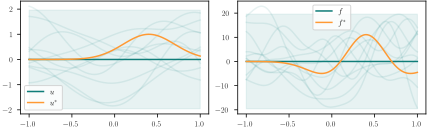

In [8]:
plot_belief(
    u=u_prior,
    f=f_prior,
)

# Observations

## Boundary Conditions 

In [9]:
X_bc, Y_bc = linpde_gp.problems.pde.get_1d_dirichlet_boundary_observations(bvp.boundary_conditions)

In [10]:
u_bc = u_prior.condition_on_observations(Y_bc, X=X_bc)

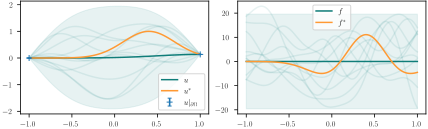

In [11]:
plot_belief(
    u=u_bc,
    f=f_prior,
    bc=True,
)

## Empirical Measurements

In [12]:
X_meas = bvp.domain.uniform_grid(10 + 2)[1:-1]
Y_meas = bvp.solution(X_meas)
err_meas = pn.randvars.Normal(
    mean=np.zeros_like(X_meas),
    cov=np.diag(np.full_like(X_meas, 0.1 ** 2)),
)

u_bc_meas = u_bc.condition_on_observations(
    X=X_meas,
    Y=Y_meas,
    b=err_meas
)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula d*Exp(-((a-b)*c)**2) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,2), d=Var(3,1,1) ... OK
[pyKeOps] Compiling pykeops cpp c20d70b38b module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula d*Exp(-((a-b)*c)**2) with a=Var(0,1,1), b=Var(1,1,0), c=Var(2,1,2), d=Var(3,1,1) ... OK
[pyKeOps] Compiling pykeops cpp 4c3bd3f89e module ... OK


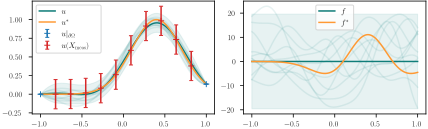

In [13]:
plot_belief(
    u=u_bc_meas,
    f=f_prior,
    bc=True,
    u_meas=(X_meas, Y_meas, err_meas),
)

# PDE

In [14]:
X_pde = bvp.domain.uniform_grid(10)
Lu_X_pde = bvp.pde.diffop(u_bc_meas)(X_pde)

u_post = u_bc_meas.condition_on_observations(
    X=X_meas,
    Y=np.zeros_like(X_meas),
    L=bvp.pde.diffop,
    b=-f_prior(X_meas),
)

f_post = f_prior.condition_on_observations(
    X=X_pde,
    Y=np.zeros_like(X_pde),
    b=-Lu_X_pde,
)

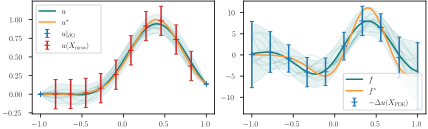

In [15]:
plot_belief(
    u=u_post,
    f=f_post,
    bc=True,
    u_meas=(X_meas, Y_meas, err_meas),
    pde_meas=(X_pde, Lu_X_pde),
)

experiment_utils.savefig("u_f_posterior")